In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Display the first few rows to check for a column that might indicate holidays
print(df.head())


             date_time is_holiday  air_pollution_index  humidity  wind_speed  \
0  2012-10-02 09:00:00       None                  121        89           2   
1  2012-10-02 10:00:00       None                  178        67           3   
2  2012-10-02 11:00:00       None                  113        66           3   
3  2012-10-02 12:00:00       None                   20        66           3   
4  2012-10-02 13:00:00       None                  281        65           3   

   wind_direction  visibility_in_miles  dew_point  temperature  rain_p_h  \
0             329                    1          1       288.28       0.0   
1             330                    1          1       289.36       0.0   
2             329                    2          2       289.58       0.0   
3             329                    5          5       290.13       0.0   
4             329                    7          7       291.14       0.0   

   snow_p_h  clouds_all weather_type weather_description  traf

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Check unique values in the 'is_holiday' column
print(df['is_holiday'].unique())

# Convert any value that is not 'None' to 1 (indicating a holiday) and 'None' to 0
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Verify the conversion
print(df['is_holiday'].value_counts())


['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
0    33707
1       43
Name: is_holiday, dtype: int64


In [3]:
# Group by the 'is_holiday' column and calculate average traffic volume
average_traffic_by_holiday = df.groupby('is_holiday')['traffic_volume'].mean()
print(average_traffic_by_holiday)

is_holiday
0    3243.182395
1     838.116279
Name: traffic_volume, dtype: float64


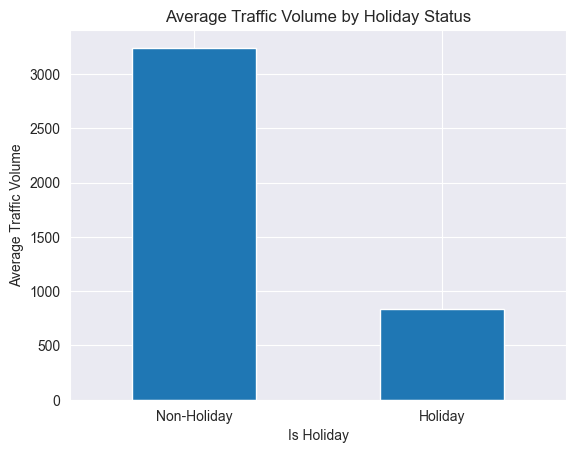

In [4]:
import matplotlib.pyplot as plt

# Plot average traffic volume by holiday status
average_traffic_by_holiday.plot(kind='bar')
plt.title('Average Traffic Volume by Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

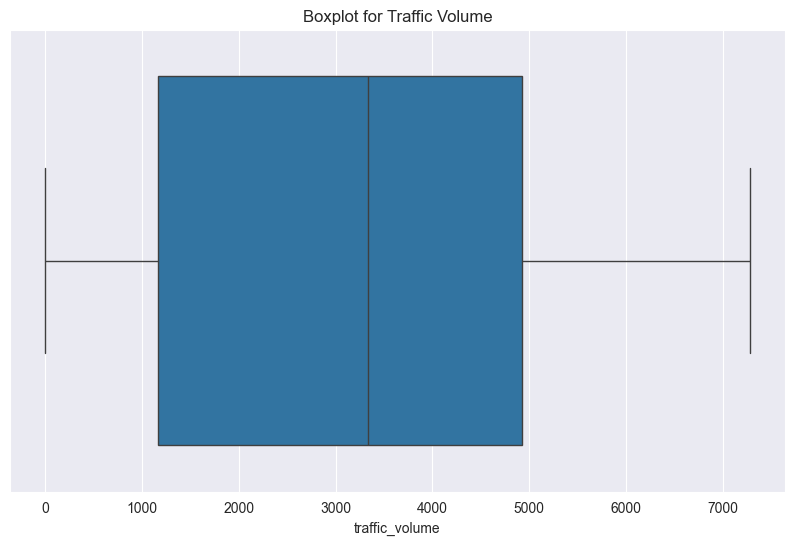

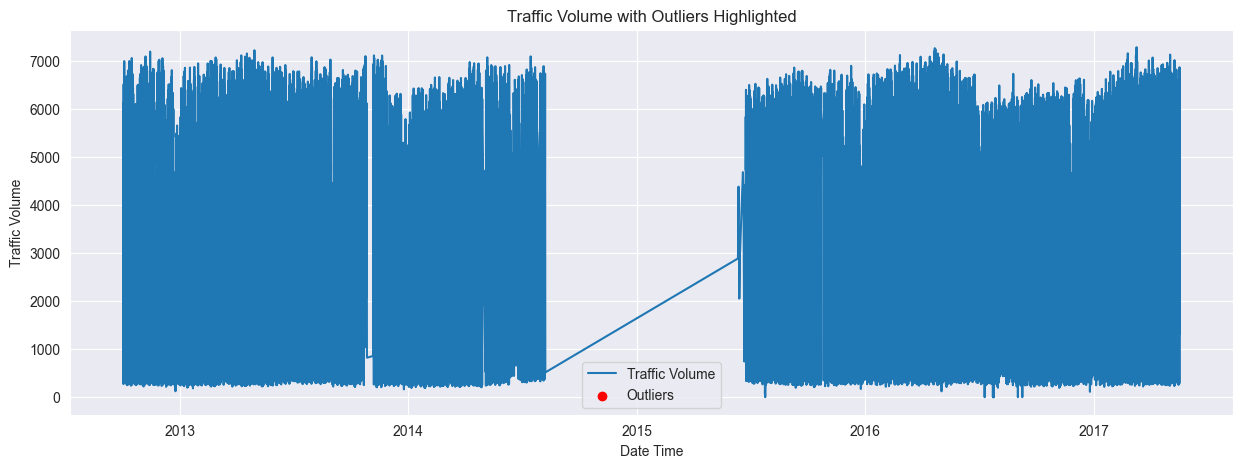

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Calculate IQR for outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = df[(df[target] < (Q1 - 1.5 * IQR)) | (df[target] > (Q3 + 1.5 * IQR))]

# Plot to visualize outliers using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[target])
plt.title('Boxplot for Traffic Volume')
plt.show()

# Plot a time series graph highlighting outliers
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[target], label='Traffic Volume')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers', zorder=5)
plt.title('Traffic Volume with Outliers Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

class TqdmRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None,
                 refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score=np.nan, return_train_score=False):
        super().__init__(
            estimator=estimator, param_distributions=param_distributions, n_iter=n_iter,
            scoring=scoring, n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, random_state=random_state, error_score=error_score,
            return_train_score=return_train_score)
        
    def fit(self, X, y, **fit_params):
        with tqdm(total=self.n_iter, desc="RandomizedSearchCV Progress") as self._tqdm:
            return super().fit(X, y, **fit_params)

    def _run_search(self, evaluate_candidates):
        """ Use tqdm with RandomizedSearchCV """
        super()._run_search(evaluate_candidates)
        
# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

end_of_A = '2014-08-08 01:00:00'  # Replace with your actual end date for Period A
df_period_A = df_raw[df_raw['date_time'] <= end_of_A]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_A.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_A.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=non_numeric_cols, drop_first=True)

# Add hour from the index
df['hour'] = df.index.hour

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Save 'date_time' for later use if needed
date_time = df['date_time']

# Exclude 'date_time' from the scaling process and model input
X = df.drop(['date_time', target], axis=1)
y = df[target]

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into train and test sets
split_index = int(len(X_scaled) * 0.9)
X_train = X_scaled[:split_index]
y_train = y[:split_index]
X_test = X_scaled[split_index:]
y_test = y[split_index:]

In [7]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300], #default 100
    'max_depth': [3, 5, 7], #default 6
    'learning_rate': [0.01, 0.1, 0.2], #default 0.300000012
    'subsample': [0.8, 0.9, 1.0], #default 1
    'colsample_bytree': [0.8, 0.9, 1.0], #default 1
    'gamma': [0, 0.1, 0.5, 1], #default 0
    'reg_alpha': [0, 0.1, 1, 10] #default 0
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the TqdmRandomizedSearchCV object with the time series cross-validator
random_search = TqdmRandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit the random search to the scaled data
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_
print(f"Best parameters found: {best_parameters}")

# Fit the random search to the scaled data
random_search.fit(X_train, y_train)

# Save the best model
best_model = random_search.best_estimator_
joblib.dump(best_model, 'best_xgboost_model.joblib')

# Get the best parameters
best_parameters = random_search.best_params_
print(f"Best parameters found: {best_parameters}")

# Evaluate metrics on the training set
y_train_pred = best_model.predict(X_train)
train_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MSE': mean_squared_error(y_train, y_train_pred),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'MAPE': mape_scorer(y_train, y_train_pred)
}

# Evaluate metrics on the validation set
y_val_pred = best_model.predict(X_test)
val_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred)),
    'MSE': mean_squared_error(y_test, y_val_pred),
    'MAE': mean_absolute_error(y_test, y_val_pred),
    'MAPE': mape_scorer(y_test, y_val_pred)
}

# Print and compare metrics
print("Training Set Metrics:")
print(train_metrics)

print("\nValidation Set Metrics:")
print(val_metrics)


RandomizedSearchCV Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV Progress:   0%|          | 0/100 [04:21<?, ?it/s]


Best parameters found: {'subsample': 0.9, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


RandomizedSearchCV Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV Progress:   0%|          | 0/100 [03:45<?, ?it/s]

Best parameters found: {'subsample': 0.9, 'reg_alpha': 10, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
Training Set Metrics:
{'RMSE': 296.84541844165096, 'MSE': 88117.20244979885, 'MAE': 185.67714452060972, 'MAPE': 8.936293364129055}

Validation Set Metrics:
{'RMSE': 419.34585735107817, 'MSE': 175850.9480775108, 'MAE': 236.59916671643154, 'MAPE': 11.256583454344755}


In [8]:
df.columns

Index(['date_time', 'air_pollution_index', 'humidity', 'wind_speed',
       'wind_direction', 'visibility_in_miles', 'dew_point', 'temperature',
       'rain_p_h', 'snow_p_h', 'clouds_all', 'traffic_volume',
       'is_holiday_Columbus Day', 'is_holiday_Independence Day',
       'is_holiday_Labor Day', 'is_holiday_Martin Luther King Jr Day',
       'is_holiday_Memorial Day', 'is_holiday_New Years Day',
       'is_holiday_None', 'is_holiday_State Fair',
       'is_holiday_Thanksgiving Day', 'is_holiday_Veterans Day',
       'is_holiday_Washingtons Birthday', 'weather_type_Clouds',
       'weather_type_Drizzle', 'weather_type_Fog', 'weather_type_Haze',
       'weather_type_Mist', 'weather_type_Rain', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze'

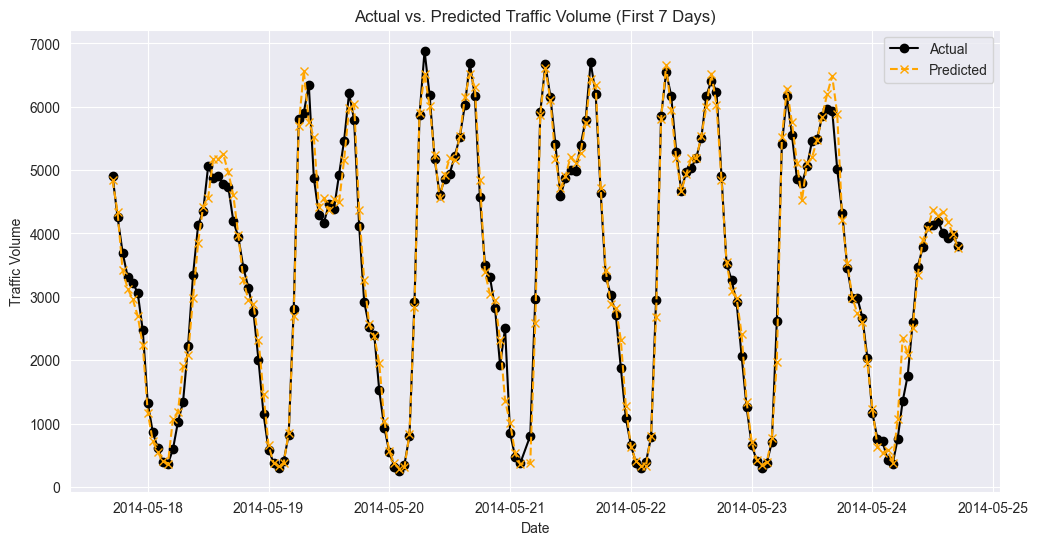

In [9]:
# Plot the actual vs. predicted traffic volume for the first 7 days
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:168], y_test.iloc[:168], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(y_test.index[:168], y_val_pred[:168], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume (First 7 Days)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [14]:
xgboost_model = xgb.XGBRegressor().fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

df_test = df.iloc[split_index:].copy()  # This is the test portion of your original DataFrame
df_test['forecasted_traffic_volume'] = y_pred  # Adding the predictions

result_df = df_test[['traffic_volume', 'traffic_volume_lag_1', 'traffic_volume_lag_2', 'traffic_volume_lag_3', 'forecasted_traffic_volume']]

forecast_steps = min(720, len(X_test))

# Rename the columns
df_test_renamed = df_test.rename(columns={
    'traffic_volume': 'actual_traffic_volume',
    'traffic_volume_lag_1': 'lag_1',
    'traffic_volume_lag_2': 'lag_2',
    'traffic_volume_lag_3': 'lag_3',
    'forecasted_traffic_volume': 'forecasted_traffic'
})

# Drop the existing 'date_time' column if it exists as a separate column
if 'date_time' in df_test_renamed.columns:
    df_test_renamed.drop('date_time', axis=1, inplace=True)

# Reset the index and rename it
df_test_reformatted = df_test_renamed.reset_index()
df_test_reformatted = df_test_reformatted.rename(columns={'index': 'date_time'})

# Display the reformatted DataFrame
forecast_steps = min(720, len(df_test_reformatted))
print(df_test_reformatted[['date_time', 'actual_traffic_volume', 'lag_1', 'lag_2', 'lag_3', 'forecasted_traffic']].head(forecast_steps))


              date_time  actual_traffic_volume   lag_1   lag_2   lag_3  \
0   2014-05-17 17:00:00                 4906.0  4893.0  5028.0  5308.0   
1   2014-05-17 18:00:00                 4258.0  4906.0  4893.0  5028.0   
2   2014-05-17 19:00:00                 3699.0  4258.0  4906.0  4893.0   
3   2014-05-17 20:00:00                 3317.0  3699.0  4258.0  4906.0   
4   2014-05-17 21:00:00                 3226.0  3317.0  3699.0  4258.0   
..                  ...                    ...     ...     ...     ...   
715 2014-07-05 04:00:00                  319.0  1471.0  2694.0  3532.0   
716 2014-07-05 05:00:00                  623.0   319.0  1471.0  2694.0   
717 2014-07-05 06:00:00                 1118.0   623.0   319.0  1471.0   
718 2014-07-05 07:00:00                 1452.0  1118.0   623.0   319.0   
719 2014-07-05 08:00:00                 2019.0  1452.0  1118.0   623.0   

     forecasted_traffic  
0           4853.810059  
1           4044.741455  
2           3445.764648  
3      